# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 13.03.2021

Мягкий дедлайн: 28.03.2021 01:59 MSK

Жёсткий дедлайн: 01.04.2021 01:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning. 



In [1]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

In [2]:
for i in range(1488):
    print("A", end='')

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [3]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''
        L = np.diag(np.sum(X, axis=0)) - X
        wa, va = np.linalg.eigh(L)
        ids = np.argpartition(wa, self.n_components - 1)[0:self.n_components]
        return va[:, ids]

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [ ]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Если вдруг сайт Правительства Москвы сойдет с ума, то возьмите какую-нибудь версию данных [отсюда](https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [43]:
%%bash
wget -q https://data.mos.ru/opendata/download/60464/1/201 -O transport.zip
mkdir -p data
unzip transport.zip -d data/

Archive:  transport.zip
  inflating: data/City surface public transport stops.xlsx  


In [44]:
data = pd.read_excel('data/City surface public transport stops.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index()
data.head()

index  ID_en  ...  global_id  geoData
0    278    347  ...  889085436      NaN
1    279    349  ...  889085437      NaN
2    355    479  ...  889085549      NaN
3    356    480  ...  889085550      NaN
4    357    481  ...  889085551      NaN

[5 rows x 16 columns]

Воспользуемся библиотекой `folium` для визуализации данных.

In [45]:
import folium

map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(map)
map

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

In [232]:
ID_COLUMN = "index"

def get_routes(data):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''
    routes = {}
    for index, row in data[[ID_COLUMN, "RouteNumbers_en"]].iterrows():
        id = int(index)
        id_routes = row["RouteNumbers_en"].split("; ")
        for route in id_routes:
            if not route in routes:
                routes[route] = []
            routes[route].append(id)
    return routes

def get_distances(data, stops):
    coords = [
        np.array([
            data.iloc[id]["Longitude_WGS84_en"], 
            data.iloc[id]["Latitude_WGS84_en"]
        ]) for id in stops]
    dist = np.zeros((len(stops), len(stops)))
    for i in range(len(stops)):
        for j in range(len(stops)):
            dist[i, j] = np.sqrt(np.sum((coords[i] - coords[j]) ** 2))
    return dist

def sort_routes(data, routes):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''
    sorted_data = {}
    for route, stops in routes.items():
        dist = get_distances(data, stops)
        inf = np.max(dist) * 2
        start = np.argmax(np.sum(dist, axis=0))
        sorted_stops_ids = [start]
        while len(sorted_stops_ids) < len(stops):
            last = sorted_stops_ids[-1]
            dist[last, last] = inf
            next = np.argmin(dist[last, :])
            sorted_stops_ids.append(next)
            dist[last, :] = inf
            dist[:, last] = inf

        sorted_data[route] = [stops[id] for id in sorted_stops_ids]

    return sorted_data

def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''
    coords = [
        np.array([
            data.iloc[id]["Longitude_WGS84_en"], 
            data.iloc[id]["Latitude_WGS84_en"]
        ]) for id in range(data.shape[0])]

    dist = np.ones((data.shape[0], data.shape[0])) * 1e9
    for route, stops in sorted_routes.items():
        for i in range(len(stops)):
            for j in range(len(stops)):
                dist[stops[i], stops[j]] = np.sqrt(np.sum((coords[stops[i]] - coords[stops[j]]) ** 2))

    return dist
 

In [233]:
routes = get_routes(data)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [236]:
map = folium.Map([55.75215, 37.61819], zoom_start=12)
for route_id in np.random.choice(list(sorted_routes.keys()), size=7):
    coords = data.loc[
        sorted_routes[route_id],
        ['Latitude_WGS84_en', 'Longitude_WGS84_en']
    ].values.tolist()
    folium.vector_layers.PolyLine(coords).add_to(map)

map

**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

In [237]:
!pip install colormap easydev

In [274]:
import matplotlib.pyplot as plt
from colormap import rgb2hex

def draw_clustered_map(data, labels):
    '''
    Create map with coloured clusters
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with coloured clusters
    '''

    print(labels)

    color_map_rgb = plt.cm.get_cmap('hsv', np.max(np.array(labels)) + 1)
    color_map = lambda x: rgb2hex(*color_map_rgb(x))
    
    map = folium.Map([55.75215, 37.61819], zoom_start=12)
    for index, row in data[[ID_COLUMN, "Longitude_WGS84_en", "Latitude_WGS84_en"]].iterrows():
        coords = row[["Latitude_WGS84_en", "Longitude_WGS84_en"]].values.tolist()
        marker=folium.CircleMarker(coords, radius=3, fill=True, color=color_map(labels[index]))
        marker.add_to(map)

    return map

**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации K-Means и DBSCAN из `sklearn` на координатах остановок, а также свою реализацию спектральной кластеризации на построенной выше матрице смежности. Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`. Подберите параметры алгоритмов (`n_clusters` у K-Means, `eps` у DBSCAN, `n_clusters` и `n_components` у спектральной кластеризации) так, чтобы получить наиболее характерный для этих алгоритмов результат кластеризации (можете поэкспериментировать и оставить в ноутбуке картинки только для итоговых значений параметров, также обратите внимание на баланс объектов в кластерах). Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [76]:
from sklearn.cluster import KMeans, DBSCAN

In [276]:
len(sorted_routes)

163

In [277]:
draw_clustered_map(data, KMeans(n_clusters=30).fit_predict(data[["Longitude_WGS84_en","Latitude_WGS84_en"]]))

[18  4 19 ... 17 23  2]


In [312]:
draw_clustered_map(data, DBSCAN(eps=0.0027, min_samples=3, algorithm="kd_tree").fit_predict(data[["Longitude_WGS84_en","Latitude_WGS84_en"]]))

[ 0  1  2 ... 35 17 76]


In [333]:
draw_clustered_map(data, GraphClustering(n_clusters=120, n_components=13).fit_predict(adjacency_matrix))

[101  36  20 ...  42  42  83]


Проинтерпретируйте полученные результаты. Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:**

1. KMeans разбивает на круглые кластеры. Он не сможет найти марштур который ездил только по садовому кольцу, например. И впринципе он не может находить маршруты, которые выглядят как цепочки. Из плюсов то, что перебирать нужно только количество кластеров.
2. DBSCAN лучше выделил маршруты-цепочки. Но пришлось повозиться, и от маленькой смены параметров может получиться совсем другой результат, так как остановки все находятся рядом. Также сложно добиться чтобы в такой задаче DBSCAN нашел много маршрутов. Если два маршрута проходят через одну точку, то DBSCAN скорее всего их объединит в один кластер.
3. GraphClustering в целом лучше справился с перекрестными маршрутами. Видно, что есть маршруты которые по прямой едут в центр Москвы. Но кажется, что марштуры-циклы не очень хорошо ищутся.

В целом KMeans точно проиграл, а из последних двух сложно выбрать победителя. GraphClustering хорошо выделил цепочки, а DBSCAN некоторые маршруты циклы. 

## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [4]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

category  ...                                            content
1289       politics  ...   Britain's economic future will be at the hear...
1872           tech  ...   A system to make it easier to create website ...
1044       politics  ...   Prime Minister Tony Blair has arrived back fr...
654   entertainment  ...   Sir Paul McCartney wowed fans with a live min...
134        business  ...   A row over whether only Greece should be allo...

[5 rows x 4 columns]

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [8]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [9]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

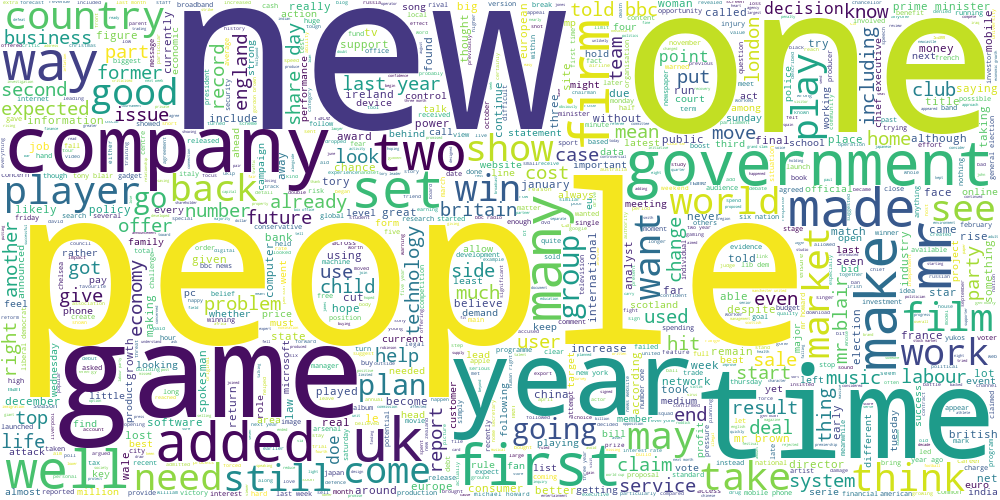

In [11]:
draw_wordcloud(data.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:**

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [46]:
model = Pipeline([
    ("build_features", TfidfVectorizer(min_df=0.1, max_features=500)),
    ("find_clusters", KMeans(verbose=0))
])

In [47]:
clusters = model.fit_predict(data.text)

In [48]:
data_text = data.text.to_numpy()

In [203]:
def draw_clusters(texts, clusters):
    NUMBER_IN_A_ROW = 4
    unique_clusters = np.sort(np.unique(clusters))
    ROWS = (len(unique_clusters) + NUMBER_IN_A_ROW - 1) // NUMBER_IN_A_ROW
    fig, axes = plt.subplots(ROWS, NUMBER_IN_A_ROW, figsize=(18, (9 * ROWS / 2)))
    
    for i in range(len(unique_clusters)):
        cluster = unique_clusters[i]
        img = draw_wordcloud(texts[clusters == cluster], max_words=100, width=500, height=500)
        axes[i // NUMBER_IN_A_ROW, i % NUMBER_IN_A_ROW].imshow(img)
        axes[i // NUMBER_IN_A_ROW, i % NUMBER_IN_A_ROW].set_title(f"cluster {cluster}")
    
    fig.show()

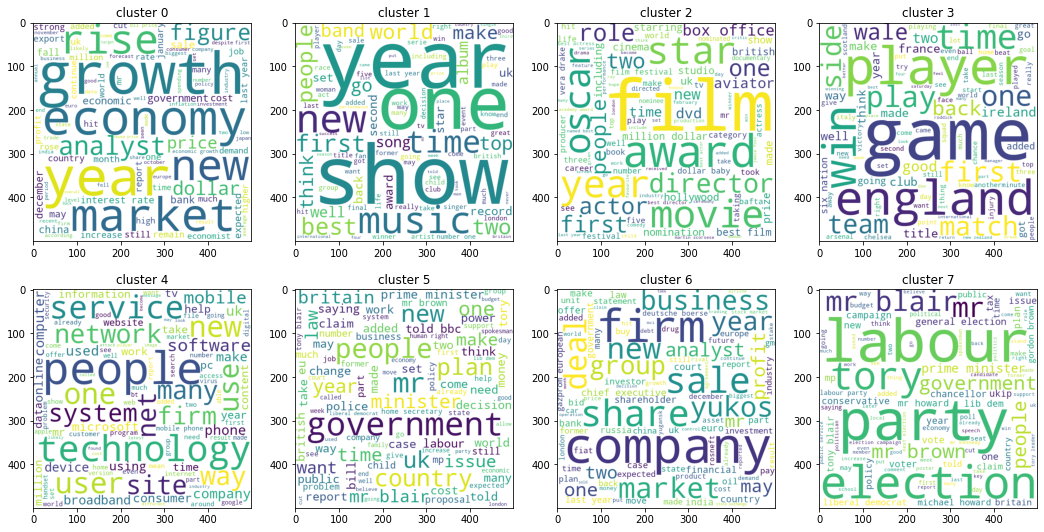

In [68]:
draw_clusters(data_text, clusters)

Темы в целом интерпретируемы, но по некоторым сложновато точно понять тематику.

**Темы**:

0. Finance
1. Music
2. Cinema
3. Sport
4. Tecnology
5. Government
6. Business
7. Elections

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:**

In [75]:
cluster_centers = model.named_steps["find_clusters"].cluster_centers_
centers_terms = model.named_steps["build_features"].inverse_transform(cluster_centers)

for i in range(cluster_centers.shape[0]):
    print("Cluster", i)
    inds = np.argsort(cluster_centers[i, :])[-8:][::-1]
    print("\t", np.array(centers_terms[i])[inds])

Cluster 0
	 ['growth' 'price' 'market' 'year' 'figure' 'month' 'analyst' 'cost']
Cluster 1
	 ['year' 'show' 'music' 'best' 'world' 'one' 'new' 'last']
Cluster 2
	 ['final' 'best' 'start' 'director' 'yet' 'one' 'also' 'five']
Cluster 3
	 ['game' 'point' 'england' 'without' 'since' 'player' 'technology' 'first']
Cluster 4
	 ['people' 'technology' 'service' 'system' 'use' 'firm' 'website' 'many']
Cluster 5
	 ['mr' 'government' 'would' 'minister' 'plan' 'country' 'people' 'told']
Cluster 6
	 ['company' 'firm' 'show' 'saying' 'deal' 'may' 'yet' 'executive']
Cluster 7
	 ['labour' 'election' 'party' 'mr' 'would' 'minister' 'leader' 'government']


**Ответ**: Немного не совпадают наборы и порядок, но в целом корреляция очень высокая.

**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [80]:
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering

In [167]:
def visualize_clusterizers(data, clusterizers_tuples):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    tfidf = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=500)
    data_featured = tfidf.fit_transform(data)
    coords = TSNE().fit_transform(data_featured)

    for i in range(len(clusterizers_tuples)):
        name, clusterizer = clusterizers_tuples[i]
        model = clusterizer
        clusters = model.fit_predict(data_featured)

        print("clusters = ", np.unique(clusters).size, np.unique(clusters))
        axes[i].set_title(name)
        color_map_rgb = plt.cm.get_cmap('hsv', max(np.unique(clusters).size, 15))
        axes[i].scatter(
            coords[:, 0], 
            coords[:, 1], 
            s=7,
            c=clusters,
            cmap=plt.cm.get_cmap('hsv', max(np.unique(clusters).size, 15))
        )
    
    fig.show()

clusters =  10 [0 1 2 3 4 5 6 7 8 9]
clusters =  10 [0 1 2 3 4 5 6 7 8 9]
clusters =  17 [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


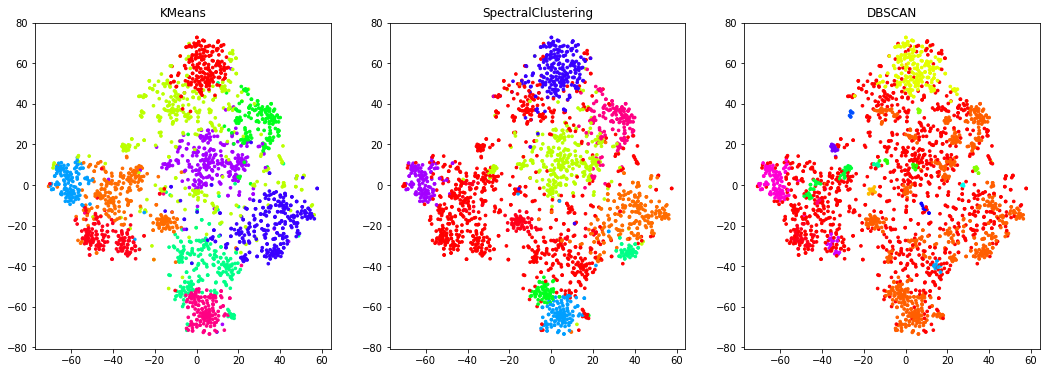

In [170]:
clusterizers = [
    ("KMeans", KMeans(n_clusters=10, n_jobs=-1, max_iter=100)),
    ("SpectralClustering", SpectralClustering(n_clusters=10, n_jobs=-1)),
    ("DBSCAN", DBSCAN(eps=1, min_samples=5)),
]


visualize_clusterizers(data_text, clusterizers)

Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:**

- KMeans и SpectralClustering справились очень похоже
- DBSCAN не получилось настроить нормально, чтобы размеры кластеров были сбалансированы. Удалось выделить только несколько кластеров, похожих на результат от KMeans и SpectralClustering
- У Kmeans кластеры снова похожи больше на круги
- У KMeans некоторые кластеры объединены, которые у SpectralClustering не объединены
- У Kmeans размеры кластеров не сильно варируются, а SpectralClustering нашел как маленькие кластеры, так и очень большие

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


In [205]:
model = Pipeline([
    ("count_vectorizer", CountVectorizer(max_features=1000)),
    ("dirichlet", LatentDirichletAllocation(n_components=25)),
    ("kmeans", KMeans(n_clusters=12))
]).fit(data_text)

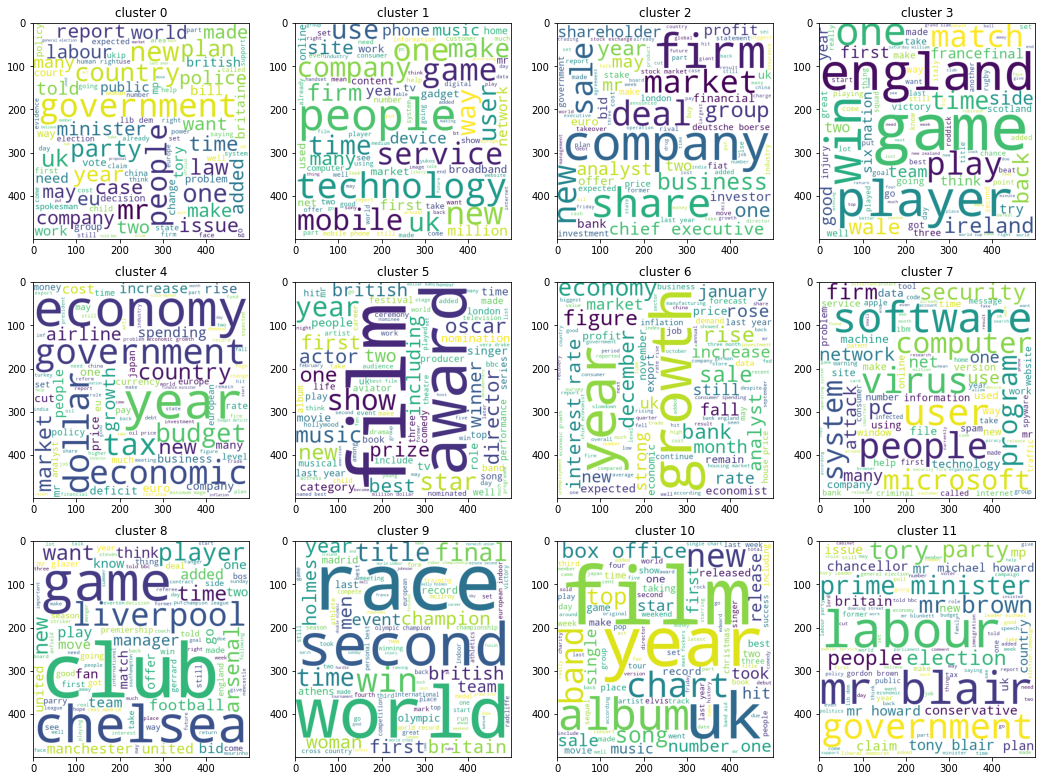

In [206]:
draw_clusters(
    data_text,
    np.array(model.predict(data_text))
)

**Вывод:**

- Новости про технологии и компьютеры разбились на два кластера (cluster 1 и cluster 7). В первом какие-то общие новости про технологии, во втором про безопасность, вирусы.
- Новости про спорт разделились. Вот видно что cluster 8 похоже про футбол. 
- Cluster 5 про награды и призы за фильмы, а cluster 10 про новые фильмы и музыку.

## Часть 3. Transfer learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [214]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [211]:
y = LabelEncoder().fit_transform(data['category'])

array([0, 0, 0, ..., 4, 4, 4])

In [257]:
def predict1(train, validation, train_known=1, logreg_params={}):
    train_X, train_y = train
    validation_X = validation
    preprocess = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=500).fit(train_X)
    model = LogisticRegression(**logreg_params)
    if train_known < 1:
        train_X_known, _, train_y_known, _ = train_test_split(train_X, train_y, test_size=1.0-train_known, stratify=train_y)
        model.fit(preprocess.transform(train_X_known), train_y_known)
    else:
        model.fit(preprocess.transform(train_X), train_y)
    
    return model.predict(preprocess.transform(validation_X))

def predict2(train, validation, train_known=1, logreg_params={}, kmeans_params={}):
    train_X, train_y = train
    validation_X = validation
    preprocess = Pipeline([
        ("tfidf", TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=500)),
        ("kmeans", KMeans(**kmeans_params)),
    ]).fit(train_X)

    # print(type(preprocess.named_steps["tfidf"].transform(train_X)))

    def to_distances(X):
        centers = preprocess.named_steps["kmeans"].cluster_centers_
        features = preprocess.named_steps["tfidf"].transform(X).todense()
        distances = np.zeros((features.shape[0], centers.shape[0]))
        for i in range(features.shape[0]):
            distances[i, :] = np.sqrt(np.sum((centers - np.array(features[i, :]).flatten()) ** 2, axis=1))
        return distances
         
    train_X = to_distances(train_X)
    validation_X = to_distances(validation_X)

    model = LogisticRegression()
    if train_known < 1:
        train_X_known, _, train_y_known, _ = train_test_split(train_X, train_y, test_size=1.0-train_known, stratify=train_y)
        model.fit(train_X_known, train_y_known)
    else:
        model.fit(train_X, train_y)
    
    return model.predict(validation_X)

def predict3(train, validation, train_known=1, logreg_params={}, dirichlet_params={}):
    train_X, train_y = train
    validation_X = validation
    preprocess = Pipeline([
        ("count_vectorizer", CountVectorizer(max_features=1000)),
        ("dirichlet", LatentDirichletAllocation(**dirichlet_params))
    ]).fit(train_X)

    model = LogisticRegression(**logreg_params)
    if train_known < 1:
        train_X_known, _, train_y_known, _ = train_test_split(train_X, train_y, test_size=1.0-train_known, stratify=train_y)
        model.fit(preprocess.transform(train_X_known), train_y_known)
    else:
        model.fit(preprocess.transform(train_X), train_y)
    
    return model.predict(preprocess.transform(validation_X))

In [251]:
print("1: accuracy =", accuracy_score(y, predict1((data_text, y), data_text)))
print("2: accuracy =", accuracy_score(y, predict2((data_text, y), data_text)))
print("3: accuracy =", accuracy_score(y, predict3((data_text, y), data_text)))

1: accuracy = 0.9851685393258427


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2: accuracy = 0.8903370786516854
3: accuracy = 0.9568539325842697


У какой модели получилось лучшее качество? С чем это связано?

**Ответ:** Лучше отработала первая модель. Полагаю нужно лучше настроить модель. Без подбора параметров часть информации может теряться. Также во второй модели возможно переобучение, так как KMeans подстраивается под данные.

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации. 

In [253]:
train_X, test_X, train_y, test_y = train_test_split(data_text, y, stratify=y, test_size=0.3)

In [312]:
print("1: accuracy =", accuracy_score(test_y, predict1(
    (train_X, train_y), 
    test_X, 
    train_known=5.0/70,
    logreg_params={
        "C": 3,
        "tol": 1e-6,
        "max_iter": 1000
    },
)))

1: accuracy = 0.9116766467065869


In [319]:
print("2: accuracy =", accuracy_score(test_y, predict2(
    (train_X, train_y), 
    test_X, 
    train_known=5.0/70,
    logreg_params={
        "C": 5,
        # "tol": 1e-6,
        "max_iter": 300
    },
    kmeans_params={
        "n_clusters": 50,
    }
)))

2: accuracy = 0.8547904191616766


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [327]:
print("2: accuracy =", accuracy_score(test_y, predict3(
    (train_X, train_y), 
    test_X, 
    train_known=5.0/70,
    logreg_params={
        "C": 1.5,
        "tol": 1e-6,
        "max_iter": 200
    },
    dirichlet_params={
        "n_components": 20,
        "max_iter": 20, 
        "learning_decay": 0.35,
    }
)))

2: accuracy = 0.9476047904191617


Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:** Дирихле показывает лучшую точность. 2-ой метод работает также не очень хорошо. Вывод такой, что дирихле неплохо использовать в условиях большой нехватки информации. Но при этом в некоторых сценариях простые алгоритмы, не склонные к переобучению, могут дать неплохой результат.

## Бонус

**Задание 4 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

In [1]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [2]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 6 (2 баллa)**. Спектральная кластеризация, по сути, является обычной кластеризацией KMeans поверх эмбеддингов объектов, которые получаются из лапласиана графа. А что, если мы попробуем построить эмбеддинги каким-нибудь другим способом? В этом задании мы предлагаем вам проявить немного фантазии. Возьмите какие-нибудь данные высокой размерности, чтобы задача обучения эмбеддингов имела смысл (например, картинки или тексты, желательно выбрать что-нибудь оригинальное). Придумайте или найдите какой-нибудь метод обучения эмбеддингов, примените его к данным и кластеризуйте полученные представления. Если чувствуете в себе достаточно силы, можете попробовать что-нибудь нейросетевое. Сравните ваш подход с базовыми алгоритмами кластеризации, которое мы рассмотрели в основном задании, не забывайте про визуализации! Ключевые слова для вдохновения: ***KernelPCA***, ***UMAP***, ***autoencoders***, ***gensim***. 

In [3]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 7 (1e-100 балла)**. Опишите свои ощущения от этой домашки, поощряется сравнение с предыдущей.

In [4]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻